# Using Time Series to more accurately predict wave heights

In [37]:
import utilities.misc as misc
import utilities.metrics as mtr
import utilities.ml_functions as ml
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import math 
import numpy as np
from matplotlib import cm

In [38]:
# convert datetime to unix
# df = pd.read_csv('clean_weather/valid_dates/m1_valid_dates.csv')
# df = pd.read_csv('clean_weather/valid_data/m1_valid.csv')
df = pd.read_csv('clean_weather/valid_dates/m2_valid_dates.csv')
# df = pd.read_csv('clean_weather/valid_data/m2_valid.csv')

start_date = min(df['time'])
end_date = max(df['time'])

df['timestamps'] = (df['date'] + ' ' +df['time'])
df['timestamps'] = pd.to_datetime(df['timestamps'])
df['timestamps'] = (df['timestamps'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')  

df.head()


,Unnamed: 0,time,station_id,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,SeaTemperature,date,timestamps
0,1953,00:00:00,M2,1020.0,330.0,2.92,3.9,0.6,4.0,NaN,NaN,8.6,2001-05-05,989020800
1,1955,01:00:00,M2,1020.8,330.0,4.09,5.8,0.4,4.0,NaN,NaN,8.6,2001-05-05,989024400
2,1957,02:00:00,M2,1020.8,350.0,4.09,5.8,0.4,4.0,NaN,NaN,8.7,2001-05-05,989028000
3,1959,03:00:00,M2,1021.2,350.0,1.95,5.8,0.4,4.0,NaN,NaN,8.7,2001-05-05,989031600
4,1961,04:00:00,M2,1021.4,30.0,2.92,5.8,0.4,4.0,NaN,NaN,8.7,2001-05-05,989035200


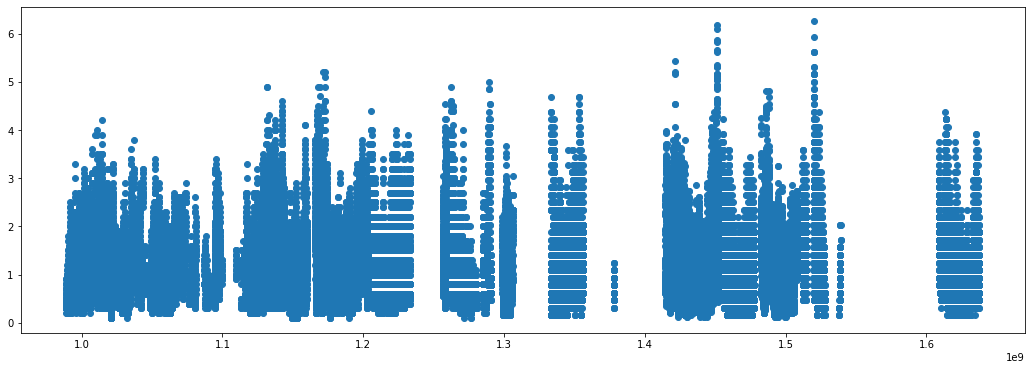

In [39]:
plt.figure(figsize=(18,6))

plt.scatter(df['timestamps'], df['WaveHeight'])
# plt.plot(df['timestamps'], df['WaveHeight'], color = 'red')


### Need to cut data into these chunks then try to predict

In [40]:
def chunkify(hours:int):
    """
    Splits dataframe into time chunks

    Parameters
    ----------
    hours : int


    Returns
    ----------
    chunk_df : pandas.dataframe
    
    """
    num_hrs = len(df)
    # hours = 24
    num_chunks = int(num_hrs/hours)
    cols = []

    data = []
    for i in range(hours):
        cols.append(f"wind{i+1}")
        cols.append(f"wave{i+1}")
        cols.append(f"atmo{i+1}")

    chunk_df =pd.DataFrame(columns=[cols])

    for j in range(num_chunks):
        # for i in range(hours):
        #     wind.append(df['WindSpeed'][i])
        #     wave.append(df['WaveHeight'][i])
        #     atmo.append(df['AtmosphericPressure'][i])
        data = []

        for i in range(j*hours,j*hours+hours ):
            data.append(df['WindSpeed'][i])
            data.append(df['WaveHeight'][i])
            data.append(df['AtmosphericPressure'][i])
        
        chunk_df.loc[len(chunk_df)] = data

    return chunk_df

In [41]:
# two_hr = chunkify(2)
# three_hr = chunkify(3)
# four_hr = chunkify(4)
# six_hr = chunkify(6)
# eight_hr = chunkify(8)
# twelve_hr = chunkify(12)
# twentyfour_hr = chunkify(24)
# twentyfour_hr
# two_hr

,wind1,wave1,atmo1,wind2,wave2,atmo2,wind3,wave3,atmo3,wind4,...,atmo21,wind22,wave22,atmo22,wind23,wave23,atmo23,wind24,wave24,atmo24
0,2.920,0.600,1020.000,4.090,0.400,1020.800,4.090,0.400,1020.800,1.950,...,1026.400,5.060,0.300,1026.600,6.030,0.400,1027.000,7.980,0.700,1027.200
1,7.980,0.800,1027.200,7.980,0.900,1027.400,6.030,0.900,1027.600,5.060,...,1030.600,5.060,0.300,1031.000,5.060,0.400,1031.000,5.060,0.500,1031.200
2,4.090,0.500,1031.600,2.920,0.400,1031.600,2.920,0.300,1031.600,4.090,...,1031.600,2.920,0.200,1031.600,1.950,0.200,1031.600,1.950,0.400,1031.600
3,1.950,0.400,1031.600,1.950,0.400,1031.400,2.920,0.300,1031.200,2.920,...,1028.800,5.060,0.400,1028.400,6.030,0.400,1028.000,7.000,0.500,1027.800
4,1.950,0.400,1020.400,7.980,0.500,1020.200,7.980,0.600,1019.800,8.950,...,1019.200,2.920,0.600,1019.800,1.950,0.500,1019.600,1.950,0.400,1019.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,7.400,0.469,1025.586,6.831,0.469,1025.037,8.681,0.469,1024.377,10.246,...,1018.042,17.362,1.094,1018.152,16.508,1.094,1018.555,18.785,1.250,1019.031
3335,21.204,1.094,1019.507,19.069,1.094,1020.093,19.781,1.250,1020.679,19.212,...,1024.048,17.362,1.094,1024.194,18.500,1.094,1024.487,17.362,1.094,1024.524
3336,18.785,1.094,1024.744,15.796,1.250,1024.817,16.081,1.094,1025.146,17.504,...,1027.454,14.943,0.938,1027.600,12.666,0.938,1027.966,13.377,0.781,1028.040
3337,12.239,0.781,1027.197,12.096,0.781,1027.051,16.081,0.625,1026.794,14.658,...,1021.667,17.931,1.250,1022.253,18.216,1.250,1021.887,19.069,1.406,1022.107


In [42]:
# pick features from chunky data

def make_features(start_col : int, end_col : int, Y_col : int, dataframe : pd.DataFrame):
    """
    makes X features from a range of adjacent columns from a pandas dataframe

    Parameters
    ----------
    start_col : int
        first column to include in feature set
    end_col : int
        last column to include in feature set
    Y_col : int
        The column to be used as a target feature

    dataframe : pd.DataFrame
        dataframe of weather data

    Returns
    -------

    X : numpy.ndarray
        array of input features
    Y : pandas.core.series.Series
    series of target features
    """
    X = dataframe.iloc[:, 0]
    # X = np.ndarray()
    for i in range(start_col+1, end_col):
        # col = 
        X = np.column_stack((X, dataframe.iloc[:, i]))
        Y = dataframe.iloc[:, Y_col]
    return X, Y
# twentyfour_hr(columns= [2])


# First experiment
## with 24 hr data try regression for up to 12 hrs earlier (intervals of 2)

In [ ]:
twentyfour_hr = chunkify(24)


# Second experiment 
## do same for 12 hour for up to 6 hours earlier

In [ ]:

twelve_hr = chunkify(12)


# Third experiment
## 8 hour

In [ ]:
eight_hr = chunkify(8)

# Final experiment
## repeating for 6 hour

In [ ]:
six_hr = chunkify(6)

### Graph all experiments together  